In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

mnist = FashionMNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 26421880/26421880 [00:45<00:00, 586065.84it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 192911.96it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:07<00:00, 599712.09it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14356567.15it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [2]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [4]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([5, 1, 9, 6, 3, 9, 6, 1, 8, 1, 5, 8, 9, 7, 8, 1, 2, 2, 7, 9, 4, 1, 4, 6,
        9, 7, 6, 2, 9, 5, 7, 0, 8, 5, 9, 3, 8, 6, 7, 7, 2, 3, 9, 6, 1, 2, 1, 1,
        6, 3, 9, 5, 5, 4, 5, 4, 7, 9, 7, 5, 9, 0, 9, 5, 1, 5, 0, 8, 0, 2, 8, 6,
        4, 9, 1, 4, 6, 1, 3, 2, 6, 8, 8, 2, 3, 2, 0, 0, 6, 0, 6, 0, 0, 0, 3, 7,
        6, 2, 5, 9])


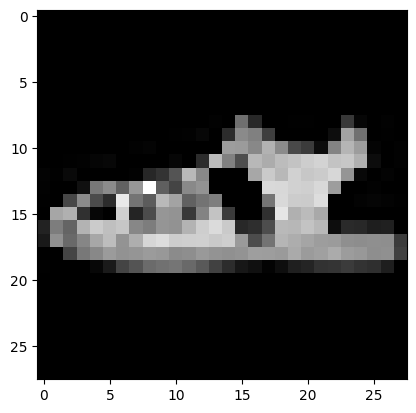

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [13]:
image_size = 784
hidden_size = 256

In [14]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [16]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [17]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [18]:
latent_size = 64

In [19]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [20]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

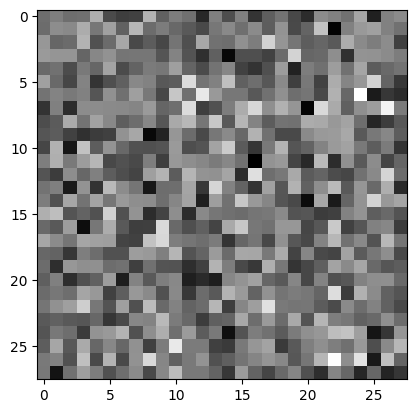

In [21]:
plt.imshow(gen_imgs[0], cmap='gray');

In [22]:
G.to(device);

In [23]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [24]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [25]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [26]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [27]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

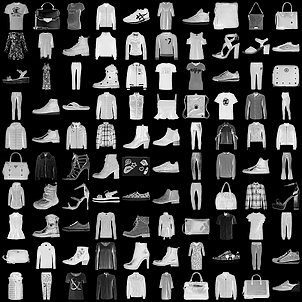

In [28]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


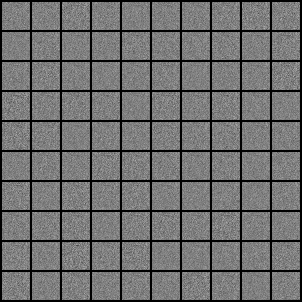

In [29]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [30]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0619, g_loss: 4.1983, D(x): 0.99, D(G(z)): 0.05
Epoch [0/300], Step [400/600], d_loss: 0.0884, g_loss: 5.9201, D(x): 0.96, D(G(z)): 0.04
Epoch [0/300], Step [600/600], d_loss: 0.0443, g_loss: 4.9409, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0259, g_loss: 5.1506, D(x): 1.00, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.0671, g_loss: 4.6039, D(x): 0.98, D(G(z)): 0.04
Epoch [1/300], Step [600/600], d_loss: 0.0329, g_loss: 6.1134, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0136, g_loss: 5.3562, D(x): 1.00, D(G(z)): 0.01
Epoch [2/300], Step [400/600], d_loss: 0.1326, g_loss: 5.9186, D(x): 0.96, D(G(z)): 0.02
Epoch [2/300], Step [600/600], d_loss: 0.0487, g_loss: 5.8104, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.1637, g_loss: 5.4750, D(x): 0.98, D(G(z)): 0.03
Epoch [3/300], Step [400/6

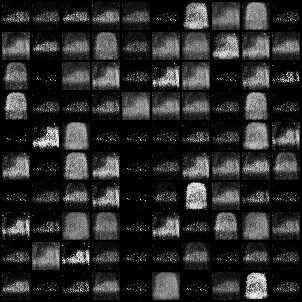

In [32]:
Image('./samples/fake_images-0010.png')

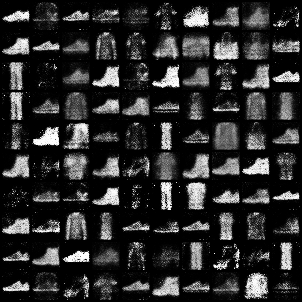

In [33]:
Image('./samples/fake_images-0050.png')

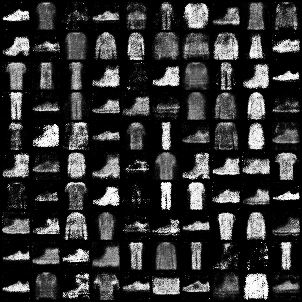

In [34]:
Image('./samples/fake_images-0100.png')

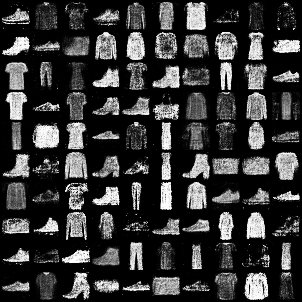

In [35]:
Image('./samples/fake_images-0300.png')

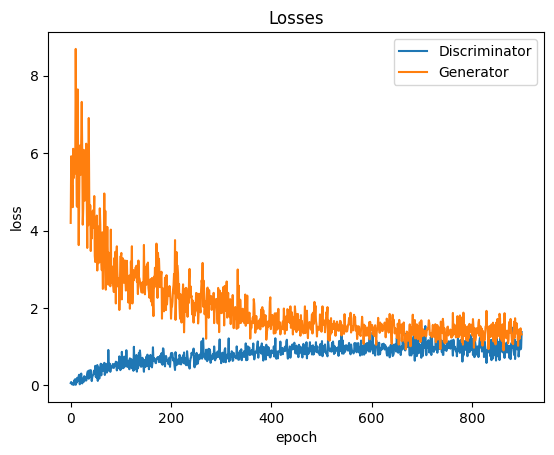

In [49]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

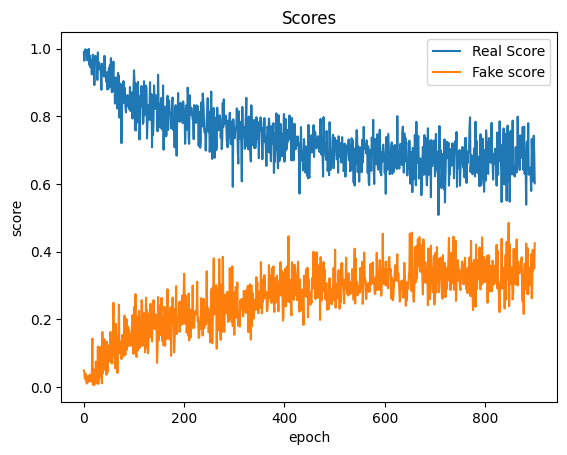

In [50]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

# Step4

In [31]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpta')

# step 5

In [53]:
# Step 5: Load the model using saved weights
G.load_state_dict(torch.load('G.ckpt'))
D.load_state_dict(torch.load('D.ckpta'))
G.to(device)
D.to(device)
print("Model weights loaded.")


Model weights loaded.


# Step 6

In [54]:
# Step 6: Re-train the GAN model to see if you can improve
num_epochs = 100  
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Save samples at the end of each epoch
    save_fake_images(epoch+1)


Epoch [0/100], Step [200/600], d_loss: 0.6084, g_loss: 1.8911, D(x): 0.79, D(G(z)): 0.25
Epoch [0/100], Step [400/600], d_loss: 1.1046, g_loss: 1.0487, D(x): 0.63, D(G(z)): 0.37
Epoch [0/100], Step [600/600], d_loss: 0.9649, g_loss: 1.3540, D(x): 0.70, D(G(z)): 0.34
Saving fake_images-0001.png
Epoch [1/100], Step [200/600], d_loss: 1.0452, g_loss: 1.1420, D(x): 0.66, D(G(z)): 0.37
Epoch [1/100], Step [400/600], d_loss: 1.2710, g_loss: 1.2247, D(x): 0.59, D(G(z)): 0.40
Epoch [1/100], Step [600/600], d_loss: 1.0370, g_loss: 1.4211, D(x): 0.65, D(G(z)): 0.30
Saving fake_images-0002.png
Epoch [2/100], Step [200/600], d_loss: 1.5203, g_loss: 0.8399, D(x): 0.63, D(G(z)): 0.52
Epoch [2/100], Step [400/600], d_loss: 1.0426, g_loss: 1.1884, D(x): 0.64, D(G(z)): 0.33
Epoch [2/100], Step [600/600], d_loss: 1.2423, g_loss: 1.2526, D(x): 0.58, D(G(z)): 0.36
Saving fake_images-0003.png
Epoch [3/100], Step [200/600], d_loss: 1.3333, g_loss: 1.1601, D(x): 0.62, D(G(z)): 0.43
Epoch [3/100], Step [400/6

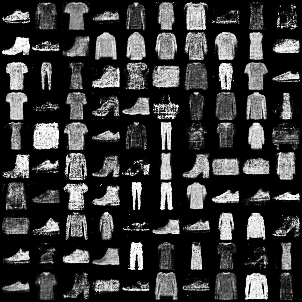

In [56]:
Image('./samples/fake_images-0100.png')

In [57]:
# step 7

In [58]:
# Step 7: Save the model weights without checkpoints
torch.save(G.state_dict(), 'G_retrained.pth')
torch.save(D.state_dict(), 'D_retrained.pth')
print("Re-trained model weights saved without checkpoints.")


Re-trained model weights saved without checkpoints.


In [59]:
# Step 8: Load the model weights without using checkpoints

In [60]:
# Step 8: Load the re-trained model weights without checkpoints
G.load_state_dict(torch.load('G_retrained.pth'))
D.load_state_dict(torch.load('D_retrained.pth'))
G.to(device)
D.to(device)
print("Re-trained model weights loaded.")


Re-trained model weights loaded.


# Question 2

In [61]:
# LSGAN Loss function
def lsgan_loss(outputs, labels):
    return 0.5 * torch.mean((outputs - labels) ** 2)


def train_discriminator_lsgan(images):
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = lsgan_loss(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = lsgan_loss(outputs, fake_labels)
    fake_score = outputs

    
    d_loss = d_loss_real + d_loss_fake

    
    reset_grad()
    
    d_loss.backward()
    
    d_optimizer.step()

    return d_loss, real_score, fake_score


def train_generator_lsgan():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device) 
    g_loss = lsgan_loss(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_images


In [62]:
torch.save(G.state_dict(), 'LSGAN_G.pth')
torch.save(D.state_dict(), 'LSGAN_D.pth')
print("LSGAN model weights saved.")


LSGAN model weights saved.


In [63]:
G.load_state_dict(torch.load('LSGAN_G.pth'))
D.load_state_dict(torch.load('LSGAN_D.pth'))
G.to(device)
D.to(device)
print("LSGAN model weights loaded.")


LSGAN model weights loaded.


In [65]:
num_epochs = 300  

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator for LSGAN
        d_loss, real_score, fake_score = train_discriminator_lsgan(images)
        g_loss, fake_images = train_generator_lsgan()

        if (i+1) % 200 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], '
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, '
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    # Sample and save images
    save_fake_images(epoch + 1)


Epoch [0/300], Step [200/600], d_loss: 0.1359, g_loss: 0.2436, D(x): 0.69, D(G(z)): 0.32
Epoch [0/300], Step [400/600], d_loss: 0.1503, g_loss: 0.2466, D(x): 0.67, D(G(z)): 0.32
Epoch [0/300], Step [600/600], d_loss: 0.1461, g_loss: 0.2204, D(x): 0.70, D(G(z)): 0.33
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.1507, g_loss: 0.2502, D(x): 0.69, D(G(z)): 0.35
Epoch [1/300], Step [400/600], d_loss: 0.1499, g_loss: 0.2436, D(x): 0.69, D(G(z)): 0.35
Epoch [1/300], Step [600/600], d_loss: 0.1611, g_loss: 0.2477, D(x): 0.66, D(G(z)): 0.35
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.1428, g_loss: 0.2525, D(x): 0.67, D(G(z)): 0.31
Epoch [2/300], Step [400/600], d_loss: 0.1583, g_loss: 0.2376, D(x): 0.69, D(G(z)): 0.36
Epoch [2/300], Step [600/600], d_loss: 0.1505, g_loss: 0.2223, D(x): 0.66, D(G(z)): 0.33
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.1641, g_loss: 0.2407, D(x): 0.65, D(G(z)): 0.35
Epoch [3/300], Step [400/6

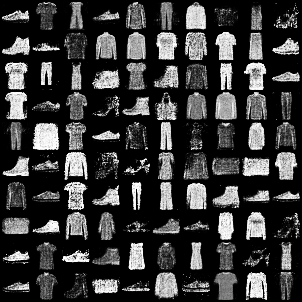

In [66]:
Image('./samples/fake_images-0300.png')

 # Describe and discuss any difficulties faced in this process.
- Time consuimg even after using GPU
- Balancing the generator and discriminator is difficult, often causing unstable training.
- The generator may produce repetitive outputs, lacking diversity.
- Gradients can become too small or large, halting or disrupting training.
- The loss function may fail to provide useful feedback for the generator's improvement.

# Compare the result

- Discriminator Loss (d_loss) remains consistently within the same range in both parts, fluctuating but not showing clear improvement or deterioration.
- Generator Loss (g_loss) also remains stable between 1.3 to 2.0, which means the generator is producing reasonable outputs, but they are still identifiable by the discriminator.
- D(x) and D(G(z)) values are also stable across both parts, reflecting that the model is not learning dramatically new strategies to either fool the discriminator or differentiate real from fake data better.